# Temperature forecasting with RNN

In [0]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

Using TensorFlow backend.


## Loading the dataset

In [2]:
# Data source https://data.gov.il/
from google.colab import files
uploaded = files.upload()

Saving ims_data.csv to ims_data.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['ims_data.csv']),usecols=['date', 'time', 'temp'])
df.head()

,date,time,temp
0,01-08-2004,02:00,25.2
1,01-08-2004,05:00,24.2
2,01-08-2004,08:00,27.3
3,01-08-2004,11:00,31.3
4,01-08-2004,14:00,29.7


## Preprocessing and feature extraction

In [0]:
def to_international_date(d):
  date = d.split('-')

  day   = date[0]
  month = date[1]
  year  = date[2]

  return '%s-%s-%s' % (year, month, day)

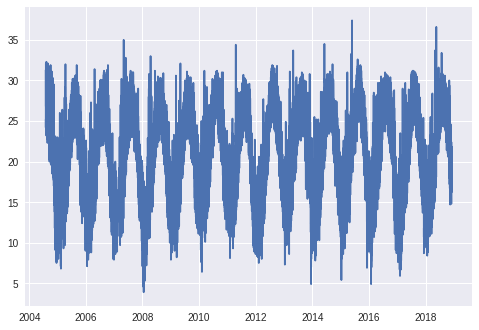

In [5]:
# Convert to the date format
df['date'] = df['date'].apply(to_international_date)

# Convert date and time to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Drop columns
df = df.drop(['date', 'time'], axis=1)

# Clean the data
df = df[df['temp'] != '-']

# Set the type of temp to float
df['temp'] = df['temp'].astype(float)

# Plot and describe the data
plt.plot(df['datetime'], df['temp'])

In [0]:
# Set the index
df = df.set_index('datetime')

In [7]:
# Describe
df.describe()

,temp
count,41142.000000
mean,21.582084
std,5.498377
min,3.900000
25%,17.300000
50%,21.900000
75%,26.500000
max,37.400000


In [8]:
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41142 entries, 2004-08-01 02:00:00 to 2018-11-30 23:00:00
Data columns (total 1 columns):
temp    41142 non-null float64
dtypes: float64(1)
memory usage: 642.8 KB


(41142, 1)

In [0]:
## Separate between the train and test datasets 

## Separate by precent
# dataset_train = df[:int(df.shape[0]*0.7)]
# dataset_test  = df[int(df.shape[0]*0.7):]

## Or better separate by time
split_date = pd.datetime(2015,12,31)

dataset_train = df[:split_date]
dataset_test  = df[split_date:]

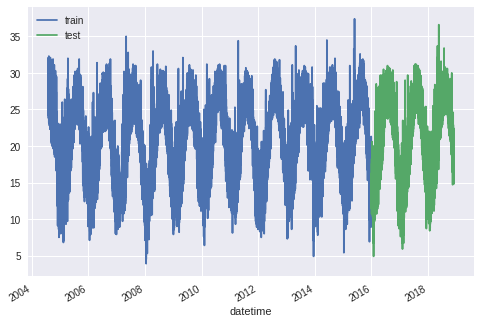

In [10]:
# Plot the datasets
ax = dataset_train.plot()
dataset_test.plot(ax=ax)
plt.legend(['train','test'])

In [11]:
# Scale the datasets
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_test_scaled  = scaler.transform(dataset_test)

print(dataset_train_scaled[:5]) # The first 5 data points
print(dataset_test_scaled[-5:]) # The last 5 data points

[[0.6358209 ]
 [0.60597015]
 [0.69850746]
 [0.81791045]
 [0.77014925]]
[[0.52835821]
 [0.53432836]
 [0.51940299]
 [0.51044776]
 [0.50746269]]


In [0]:
# Takes a series of 30 time points as feature and the next point as label
def create_dataset(df):
  x = [] # features from the previous 50 time points
  y = [] # labels from the current time points
  
  for i in range(30, df.shape[0]):
    x.append(df[i-30:i,0])
    y.append(df[i,0])
    
  x = np.array(x)
  y = np.array(y)
  
  return x,y

In [0]:
x_train, y_train = create_dataset(dataset_train_scaled)

In [0]:
x_test, y_test = create_dataset(dataset_test_scaled)

In [15]:
print(x_train.shape)
print(x_test.shape)

(32705, 30)
(8377, 30)


In [0]:
# Reshape data for LSTM layer
# Make a 2 dimensional tuple into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
print(x_train.shape)
print(x_test.shape)

(32705, 30, 1)
(8377, 30, 1)


## The model

In [18]:
model = Sequential()

model.add(LSTM(units=48, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=48, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=48))
model.add(Dropout(0.2))

model.add(Dense(units=1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 48)            9600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 48)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 48)            18624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 48)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 49        
Total para

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=2,
                   mode='auto')

In [22]:
model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test,y_test), callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 32705 samples, validate on 8377 samples
Epoch 1/200
32705/32705 [==============================] - 63s 2ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 2/200
32705/32705 [==============================] - 60s 2ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 3/200
32705/32705 [==============================] - 60s 2ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 4/200
32705/32705 [==============================] - 60s 2ms/step - loss: 0.0046 - val_loss: 0.0082
Epoch 5/200
32705/32705 [==============================] - 59s 2ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 6/200
32705/32705 [==============================] - 60s 2ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 7/200
32705/32705 [==============================] - 60s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/200
32705/32705 [==============================] - 60s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/200
32705/32705 [==============================

## Assess the model

Text(0.5, 1.0, 'Actual vs predicted in the train dataset')

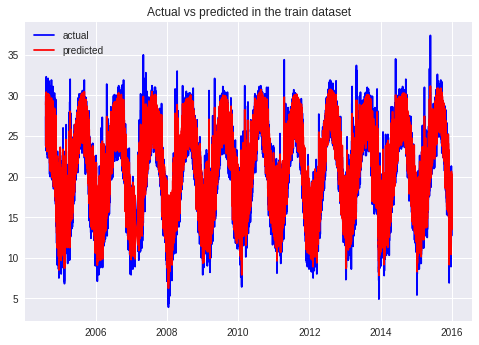

In [25]:
# First, predict from the train dataset
predicted_train = model.predict(x_train)

# Convert the scaled data back to the original values
predicted_train_rescaled = scaler.inverse_transform(predicted_train)

# Plot
# Pop the first 30 values from the timeseries
x_axis = dataset_train.index[30:]

# Visualize the predicted values against the actual data
#  but first we need to convert back to the actual data
actual_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

plt.plot(x_axis, actual_train_rescaled, 'b')
plt.plot(x_axis, predicted_train_rescaled, 'r')
plt.legend(['actual','predicted'])
plt.title("Actual vs predicted in the train dataset")

In [28]:
import math
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(actual_train_rescaled, predicted_train_rescaled))
print('Train Score: %.2f RMSE' % (train_score))

Train Score: 1.11 RMSE


In [0]:
# Predict on the test dataset
predictions = model.predict(x_test)

# Convert back to the original values
predictions = scaler.inverse_transform(predictions)

Text(0.5, 1.0, 'Actual vs predicted in the test dataset')

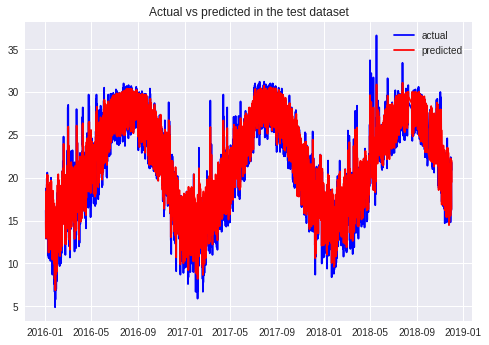

In [30]:
# Plot
# Pop the first 30 values from the timeseries that
x_axis = dataset_test.index[30:]

# Visualize the predicted values against the actual data
#  but first we need to convert back the actual data
actual_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize the predicted values against the actual data
plt.plot(x_axis, actual_test_rescaled, 'b')
plt.plot(x_axis, predictions, 'r')
plt.legend(['actual','predicted'])
plt.title("Actual vs predicted in the test dataset")

In [31]:
test_score = math.sqrt(mean_squared_error(actual_test_rescaled, predictions))
print('Test Score: %.2f RMSE' % (test_score))

Test Score: 1.06 RMSE
